In [1]:
import os
# os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Pendulum')
os.chdir(r'C:\Users\Feliz\Desktop\jupyter\DeepOnet_General\Pendu')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data = scipy.io.loadmat('Data.mat')

Input = torch.tensor(Data['F'], dtype = torch.float32).to(device)
Output = torch.tensor(Data['U'], dtype = torch.float32).to(device)

COOR = torch.tensor(Data['coors']).permute(1,0).cuda()
coor  = COOR.repeat(len(Input),1,1).float()

Input = Input[:,:,None]
Output = Output[:,:,None]

Yc = Output.squeeze()
Yc_mean = torch.mean(Yc,axis=0)
Yc = Yc - Yc_mean
n = len(Yc)
C = 1 / (n - 1) * Yc.T @ Yc
w, v = torch.linalg.eigh(C)
v = torch.fliplr(v)
v *= len(Yc_mean) ** 0.5
Bases = v[None,:,:]
Bases = Bases/torch.max(Bases)

Length = len(Input)

# torch.manual_seed(0)
# np.random.seed(0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
batch_size = 16

x_data = Input
cx_data = coor
y_data = Output

x_train = x_data[0:int(0.8*Length),:,:]
cx_train = cx_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
cx_test = cx_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, cx_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, cx_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [3]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,c.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x1 = self.MLP(x)

        c = self.encoder(c)
        c = F.gelu(c)
        c = self.w1(c)
        c = F.gelu(c)
        c = self.w2(c)
        c = F.gelu(c)
        c = self.w3(c)
        c = F.gelu(c)
        c = self.w4(c)
        c = F.gelu(c)
        c = c*x1

        y = torch.sum(c,2)

        return y

class POD_DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length, basis):
        super(POD_DeepOnet, self).__init__()

        self.encoder = nn.Linear(1, width_trunk) # input channel is 2: (a(x), x)
        self.B = basis[:,:,:width_trunk]
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,c.size(1)).permute(0,2,1)
        # print(x.size())
        x1 = self.MLP(x)

        B = self.B.repeat(x.size(0),1,1)
        c = B*x1

        y = torch.sum(c,2)

        return y


In [4]:
model = POD_DeepOnet(width_trunk = 128, width_branch = 128, length = 256, basis = Bases).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 500

Rec = []

best_loss = np.inf
patience_counter=0
best_weights = None
patience = 300

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    Re_mse = 0
    Be_mse = 0
    ne = 0
    nt = 0
    for x, cx, y in train_loader:
        ne += 1
        x, cx, y = x.cuda(), cx.cuda(), y.cuda()

        optimizer.zero_grad()
        # cx.requires_grad = True
        # ct.requires_grad = True
        out = model(x,cx)
        # dsdx = autograd.grad(out,cx,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
        # dsdxdx = autograd.grad(dsdx,cx,torch.ones_like(dsdx).to(device),retain_graph=True,create_graph=True)[0]
        # dsdt = autograd.grad(out,ct,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]

        # pde = dsdt + out[:,:,None]*dsdx - 0.001*dsdxdx

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        # Re = F.mse_loss(pde, torch.zeros_like(pde))*1e-3

        mse = De #+ Re

        mse.backward() # use the l2 relative loss
        optimizer.step()

        # Be_mse += Be.item()
        De_mse += De.item()
        # Re_mse += Re.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, cx, y in test_loader:
            nt += 1
            x, cx, y = x.cuda(), cx.cuda(), y.cuda()

            out = model(x,cx)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    Re_mse /= ne
    Be_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, Re_mse, Be_mse, test_mse)
#%%
    recording = [t2-t1, De_mse, Re_mse, Be_mse, test_mse]
    Rec.append(recording)

165248
0 3.045088399999999 0.025489788631210104 0.0 0.0 0.0055807941863313315
1 3.9480736999999984 0.0045804994058562445 0.0 0.0 0.004424482633825392
2 3.7604463000000017 0.003770222321269102 0.0 0.0 0.0037265011146664618
3 3.7428331999999997 0.003273320043925196 0.0 0.0 0.003454744989518076
4 3.5827732999999995 0.002972386869136244 0.0 0.0 0.0031401191484183074
5 3.6649154000000053 0.0027132767714792864 0.0 0.0 0.0028524080847855656
6 3.6230812999999955 0.002541290688503068 0.0 0.0 0.0026230979480315
7 3.6710490000000036 0.0023856690149987115 0.0 0.0 0.002659938069060445
8 3.607553800000005 0.0022131093608331867 0.0 0.0 0.0031924474453553556
9 3.6527328000000026 0.002089271605073009 0.0 0.0 0.0022252026004716753
10 3.7417998000000026 0.0019545717823784797 0.0 0.0 0.002111378280213103
11 3.841302600000006 0.0018596997433051002 0.0 0.0 0.0019183069164864718
12 3.815593800000002 0.0017505826927372255 0.0 0.0 0.0018930905017768963
13 3.923428399999999 0.0016347515270754228 0.0 0.0 0.00175

In [ ]:
mdic1 = {'Rec':Rec}
scipy.io.savemat(r'Dp_POD_training.mat',mdic1)

torch.save(model, 'Dp_POD_model')

torch.Size([256])


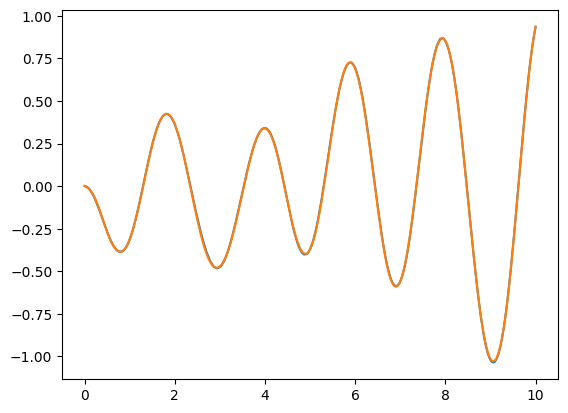

In [ ]:
num = 10 #
x = x_test[num,:,:][None,:,:].cuda()
c = cx_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
# x = torch.ones(1,n,1).cuda() + 10
out = model(x,c).squeeze().cpu()
print(out.size())

plt.figure()
plt.plot(c.squeeze().cpu().detach().numpy(),y.squeeze().detach().numpy())
plt.plot(c.squeeze().cpu().detach().numpy(),out.detach().numpy())
plt.show()

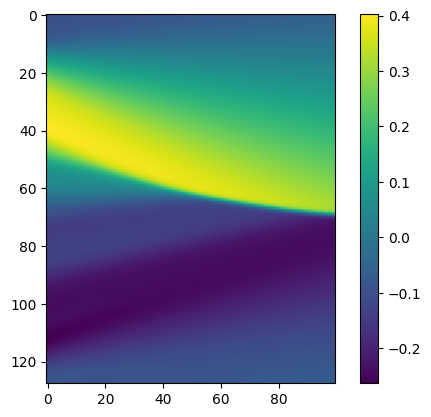

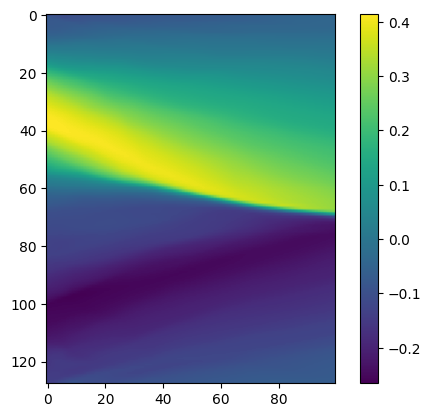

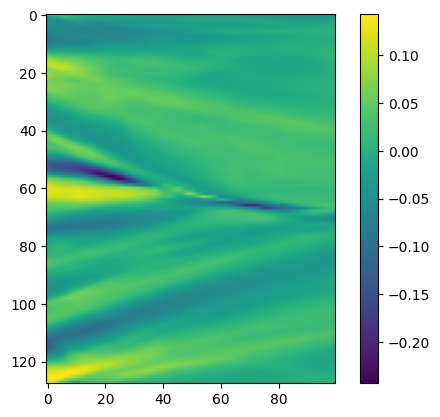

In [ ]:
k = 0
x = x_test[k,:,:][None,:,:].cuda()
cx = cx_test[k,:,:][None,:,:].cuda()
y = y_test[k,:,:][None,:,:].cuda()
# x = torch.ones(1,n,1).cuda() + 10
out = model(x,cx,ct).squeeze().cpu()

yt = y.squeeze().cpu()
yt = y.squeeze().cpu()
yp = out.squeeze().cpu()
num = int((len(yt))**0.5)

yt = torch.reshape(yt,(128,100))
yp = torch.reshape(yp,(128,100))

plt.figure(1)
plt.imshow(yt)
plt.colorbar()
plt.figure(2)
plt.imshow(yp.detach().numpy())
plt.colorbar()
plt.figure(3)
plt.imshow((yt-yp.detach().numpy())/torch.max(abs(yt)))
plt.colorbar()